# Lab 4 Report

Prepared by Zech Wolf

## 1. Loading the data

### 1.1 Read and clean NAs

In [1]:
import pandas as pd

df = pd.read_csv("datasets/acs2017_census_tract_data.csv")

In [2]:
df.dropna(inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder

#Encode the strings as ints with a label encoder
le = LabelEncoder()
df.State = le.fit_transform(df.State)

df.drop(columns=["TractId", "County"], inplace=True) #get rid of tract ID and county

I decided to get rid of the county feature. Although there are reasons to think that county could be a helpful piece of information for classification (tracts in the same county might be similar), there are nearly 2000 counties in the dataset. Since the county needs to be one hot encoded before training the networks, this means that keeping counties in the dataset will increase the dimensionality by almost 2000, and make the dataset much more sparse. I think the downsides of increasing the dimensionality will outweight any potential benefit of having county as a feature.

I decided to keep the County feature in the dataset. Each observation in the datset is a census tract, which is a subdivision of a county. This means that multiple samples will belong to the same county. As such, tracts in the same county are likely physically close to one another, and could be subject to similar laws and regulations. So the county could be a valuable piece of information for classification. A potential downside is that there are a good number of unique counties, so the one hot encoding will have high dimensionality. Even so, I think it is probably worth it to still include the county.

I also decide to get rid of the tract ID. This is just a unique identifier value for each census tract. As far as I can tell there is nothing informative about the numerical value, so this feature is probably not important for classification.

### 1.2 Quantizing child poverty

The target is calculated using the quartiles of the ChildPoverty variable, ensuring the classes are balanced as much as possible

In [4]:
import numpy as np

#df["target"] = pd.qcut(x=df.ChildPoverty, q=4, labels=False)
df["target"] = pd.cut(x=df.ChildPoverty, bins=[-1,10,20,60,100], labels=False)

In [5]:
#Check the balance of the target
np.bincount(df.target)

array([25822, 15866, 27875,  3155])

### 1.3 Train-test split

In [6]:
from sklearn.model_selection import train_test_split

#Splitting as df for now to make manipulation easier
#Need to get the numpy arrays before fitting the models though
df_train, df_test = train_test_split(df, train_size=0.8, stratify=df["target"], random_state=1234)

It is important that the classes are balanced in both the training and testing sets. Since we are assuming that classification is equally important for all classes in the dataset, a balanced training set means that a classifier has a roughly equal number of instances from each class to train on and learn how to identify. A balanced training set means that the accuracy of the predictions on the training set is actually representative of the performance of the model, according to the criteria that the classes are equally important.

No. change to common sense thresholds. train should be balanced but test should not.

## 2. Preprocessing and Initial Modeling

### 2.1 Two-Layer Perceptron Implementation

This implementation uses:
* Binary cross entropy
* Mini batching
* Glorot and He weight initialization
* Vectorized gradient computation

In [7]:
from scipy.special import expit

class TLPBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [8]:
import sys
class TwoLayerPerceptron(TLPBase):
    def __init__(self, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for k in range(self.epochs):

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                # shuffle the data so batches ar different
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2

            self.cost_.append(mini_cost)

### 2.2 Testing procedure

I define a function to fit a neural network on the training data and predict on the testing set. The accuracy is printed alongside the loss curve.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

sns.set_theme()

def plot_cost(cost_avg, show=True):
    sns.lineplot(x=range(len(cost_avg)), y=cost_avg)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    if show: plt.show()

def eval_nn(nn):
    #Get the numpy arrays
    X_train = df_train.drop(columns="target").to_numpy()
    X_test = df_test.drop(columns="target").to_numpy()
    y_train = df_train["target"].to_numpy()
    y_test = df_test["target"].to_numpy()

    nn.fit(X_train, y_train, print_progress=1)
    y_pred = nn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    cost_avg = np.apply_along_axis(np.mean, 1, nn.cost_)
    plot_cost(cost_avg)
    print(f"The network achieved an accuracy of: {acc}")

    return cost_avg, acc

### 2.3 Performance on unprocessed data

In [10]:
tlp = TwoLayerPerceptron(C=.01, epochs=50, minibatches=len(df_train)/10) #use the same object and retrain on each dataset
performance = dict() #to store the performance info for comparison later

Epoch: 50/50

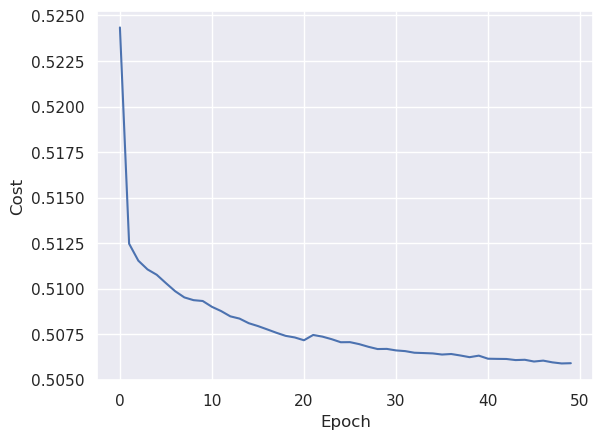

The network achieved an accuracy of: 0.3835258525852585


In [11]:
performance["No preprocessing"] = eval_nn(tlp)

### 2.4 Performance on normalized continuous features

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#Normalize the features
for col in df.columns:
    if col not in ["State", "target"]: #dont scale target or categorical features
        df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1,1))
        df_test[col] = scaler.fit_transform(df_test[col].values.reshape(-1,1)) #fit scaler separately to avoid data snooping

Epoch: 50/50

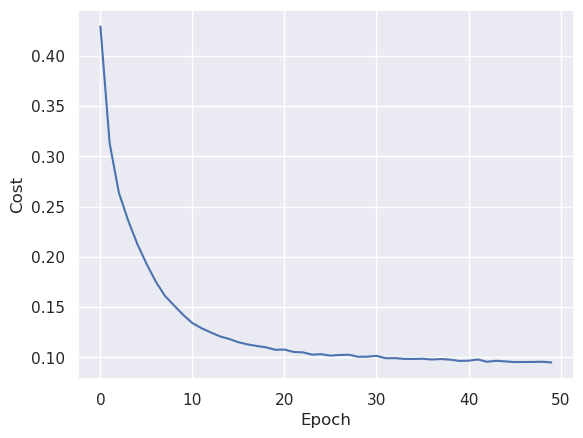

The network achieved an accuracy of: 0.931930693069307


In [13]:
#Test the network
performance["Normalization"] = eval_nn(tlp)

### 2.5 Performance on OHE and normalized features

In [11]:
col = "State" #only state needs to be ohe

#Get the encodings
ohe_train = pd.get_dummies(df_train[col], drop_first=True)
ohe_test = pd.get_dummies(df_test[col], drop_first=True)

#Drop the original columns
df_train.drop(columns=[col], inplace=True)
df_test.drop(columns=[col], inplace=True)

#Add in the OHE columns
df_train = pd.concat([ohe_train, df_train], axis=1)
df_test = pd.concat([ohe_test, df_test], axis=1)

Epoch: 50/50

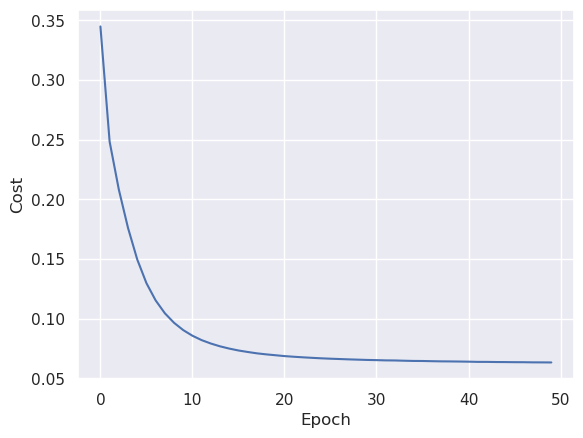

The network achieved an accuracy of: 0.9813668866886689


In [15]:
performance["Normalization and OHE"] = eval_nn(tlp)

### 2.6 Preprocessing technique comparison

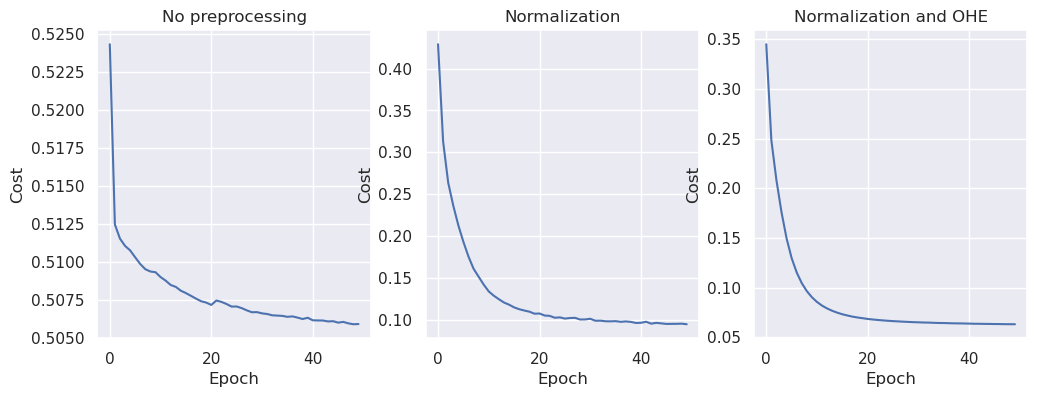

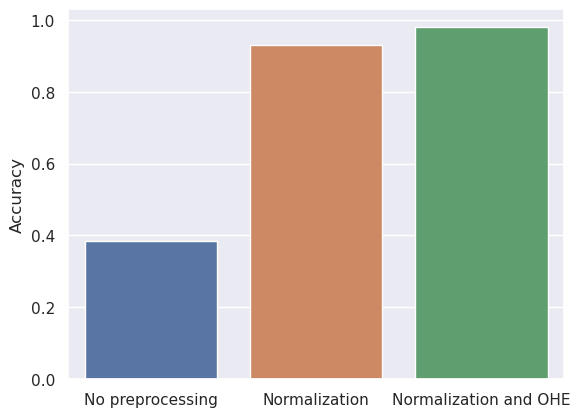

In [31]:
plt.figure(figsize=(12,4))

accs = list()
i = 1
for label, p in performance.items():
    cost = p[0]
    accs.append(p[1])

    plt.subplot(1,3,i)
    plot_cost(cost, show=False)
    plt.title(label)

    i += 1

plt.show()

sns.barplot(x=list(performance.keys()), y=accs)
plt.ylabel("Accuracy")
plt.show()

## 3. Multilayer networks

### 3.1 Implementation

I use a single class to create a neural network with the number of layers given in the constructor

In [25]:
class MLPClassifier:
    def __init__(self, n_layers=2, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.n_layers = n_layers
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""

        W = []
        b = [] #weights and biases for each layer stored in a list, biases has placeholder at start to help with indexing

        #Init weights for input layer
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        W.append(W1)
        b1 = np.zeros((self.n_hidden, 1))
        b.append(b1)

        #Init weights for hidden layers
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        for n in range(1,self.n_layers - 1):
            Wn = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
            bn = np.zeros((self.n_hidden, 1))
            W.append(Wn)
            b.append(bn)
        
        #Init weights for the output layer
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        Wf = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        W.append(Wf)

        #Final bias
        bf = np.zeros((self.n_output_, 1))
        b.append(bf)
        
        return W, b
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        s = 0
        for Wn in W: #get the sum of the terms from each weight matrix
            s += np.mean(Wn[:, 1:] ** 2)

        return (lambda_/2.0) * np.sqrt(s)
    
    def _cost(self, Af, Y_enc, W): #Af is the activations of the final layer
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(Af)+(1-Y_enc)*np.log(1-Af))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W, b):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W : array of weight matrices for each layer
        b : array of bias vectors for each layer
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A = [X.T] #start with the input layer activation
        for n in range(self.n_layers):
            Zn = W[n] @ A[n] + b[n]
            A_next = self._sigmoid(Zn)
            A.append(A_next)

        return A
    
    def _get_gradient(self, A, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V = [A[-1] - Y_enc] #list of sensitivities in descending layer order
        for n in range(1,self.n_layers):
            Vn = A[-n-1]*(1-A[-n-1])*(W[-n].T @ V[n-1]) #A is in ascending order, use negative indexing
            V.append(Vn)


        gradW = []
        gradb = [] #store the gradients for each weight and bias

        V.reverse() #get V in the same layer order as A 
        for n, Vn in enumerate(V):
            gradWn = (Vn @ A[n].T) + (W[n] * self.l2_C)
            gradbn = np.sum(Vn, axis=1).reshape((-1,1))
            gradW.append(gradWn)
            gradb.append(gradbn)

        return gradW, gradb
        # V1 = A2*(1-A2)*(W2.T @ V2)
        
        # gradW2 = V2 @ A2.T
        # gradW1 = V1 @ A1.T
        
        # gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        # gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # # regularize weights that are not bias terms
        # gradW1 += W1 * self.l2_C
        # gradW2 += W2 * self.l2_C

        # return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        A = self._feedforward(X, self.W, self.b)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()

        self.cost_ = []
        self.gradW_ = np.empty((self.epochs,self.n_layers)) #stores average gradient magnitude of each layer
        for k in range(self.epochs):

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                # shuffle the data so batches ar different
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A = self._feedforward(X_data[idx], self.W, self.b)
                
                cost = self._cost(A[-1], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW, gradb = self._get_gradient(A, Y_enc[:,idx], self.W)

                for i in range(len(self.W)):
                    self.W[i] -= self.eta * gradW[i]
                    self.b[i] -= self.eta * gradb[i]
                    self.gradW_[k,i] = np.mean(np.abs(self.W[i]))

            self.cost_.append(mini_cost)

    def plot_grad_(self):
        for n in range(self.n_layers):
            sns.lineplot(x=range(self.epochs), y=self.gradW_[:,n])

In [23]:
X_train = df_train.drop(columns="target").to_numpy()
X_test = df_test.drop(columns="target").to_numpy()
y_train = df_train["target"].to_numpy()
y_test = df_test["target"].to_numpy()

nn = MLPClassifier(epochs=5, n_layers=3, minibatches=len(df_train/10), C=.001)
nn.fit(X_train, y_train, print_progress=1)

Epoch: 5/5

In [24]:
yhat = nn.predict(X_test)

accuracy_score(y_test, yhat)

0.9337183718371838